<a href="https://colab.research.google.com/github/isippalpers/Atmospheric_chem/blob/main/EAS4610_Final_HM_ISA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Video Walkthrough:

## **Introduction**

The primary objective or main theme of this study is to investigate the dynamics of the jet stream under zonally asymmetric thermal forcing. The jet stream is a fast-moving current of air that exists between $6-13$ kilometers above Earth's surface. The jet stream exists because of the thermal wind relationship. As the horizontal temperature gradient increases, vertical geostrophic wind sheer also increases. The vertical geostrophic wind sheer over regions with the greatest horizontal tempertaure gradient is known as the jet stream. The governing partial differential equation (PDE) describes the evolution of geopotential anomalies due to differences in thermal forcing, atmospheric stability, and zonal wind dissipation. Solving this equation provides insights into the effects of global warming and uneven surface heating on jet stream amplitude, which impacts extreme weather events like droughts and floods.

### **Why is this important?**
The behavior of geopotential anomalies determines the strength and persistence of jet stream troughs and ridges. These meanders, when amplified, can lead to extreme weather events. By solving this PDE, we can predict how such anomalies evolve under different atmospheric conditions.

### **Comparison to Other Studies**
Unlike earlier studies:
1. **Observational Models**: Focused on historical satellite and reanalysis data but lacked process-level resolution.
2. **Barotropic Models**: Captured horizontal jet stream behavior but ignored vertical dissipation and stability.
3. **Coupled Climate Models**: Simulated broader climate systems but often excluded zonally asymmetric forcing at the process level.

This study uses numerical and analytical solutions to directly investigate the dynamics of geopotential anomalies, bridging the gap between simplified and fully coupled models.

---

# Equations

The governing equations, which are derived from linearized equations for planetary geostrophy, are:

[1]
$$
\
\phi_L(x, z) = \frac{Q_0 F(x)}{U(k_s^2 + \frac{1}{H} k_s) + \beta_L S}
\left[
\frac{e^{\frac{1}{2H} + q} - e^{-k_s}}{2e^{\frac{1}{2H}} \sinh(q)} e^{\left(\frac{1}{2H} + q\right)z}
+ \frac{e^{\frac{1}{2H} + q} - e^{-k_s}}{2e^{\frac{1}{2H}} \sinh(q)} e^{\left(\frac{1}{2H} - q\right)z}
- \left(k_s + \frac{1}{H}\right) e^{-k_s z}
\right]
\
$$

which describes the analytical solution, and

[2]
$$
\frac{\partial^2 \phi_L}{\partial z^2}
- \frac{1}{H} \frac{\partial \phi_L}{\partial z}
+ \frac{\beta_L S}{U} \phi_L
= -\left(k_s + \frac{1}{H}\right) \frac{Q_0}{U} F(x) e^{-k_s z}
$$

which we used to numerically solve for Geopotential Height Anomaly.

### **Terms and Parameters**
- $\phi_L$: Streamfunction perturbation amplitude (geopotential height).
- $F(x)$: Zonal thermal forcing distribution $(\sin(2x)/2$).
- $Q_0$: Surface thermal forcing amplitude.
- $H$: Scale height (atmospheric stratification scale).
- $U$: Zonal wind velocity.
- $k_s$: Decay constant for dissipation.
- $\beta_L$: Meridional gradient of the Coriolis parameter.
- $S$: Atmospheric stability parameter.
- $q$: Derived stability term $(\sqrt{\frac{1}{4H^2} - \frac{\beta_L S}{U}}$).


In [ ]:
#defining parameters, boundary conditions, initial conditions
#model code
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Parameters
Lx = 2 * np.pi
Lz = 1.0
Nx = 120
dx = Lx/Nx
Nz = 15
dz = Lz/Nz

# Given constants
ks = 2.0
H = 0.5
beta_L = 1.0
S = 1.0
U = 1.5
Q0 = 0.8

def F(x):
  return np.sin(2*x)/2


### **Assumptions**
- Linearized dynamics.
- Dry atmosphere (no moisture feedback).

## **Numerical Methods**

### **Methods Used**
1. **Discretization**: Vertical $(z$) and horizontal $(x$) dimensions are discretized using finite differences.
2. **Matrix Solver**: PDE reformulated into a tridiagonal matrix and solved iteratively using `numpy.linalg.solve`.
3. **Validation**: Numerical solutions are compared to the analytical solution to validate accuracy.

### **Why These Methods?**
- The tridiagonal matrix approach ensures computational efficiency and stability for linear PDEs.
- Analytical solutions provide a benchmark to evaluate numerical accuracy.

### **Boundary Conditions**
We used two, zonally-variable Dirichlet boundary conditions according to Equation 1.
1. **Dirichlet at ($z$ = $0$)**:  $\phi_L(z = 0, x = x) = \phi_0$
2. **Dirichlet at ($z$ = $L_z$)**: $\phi_L(z=L_z, x = x) = \phi_z$


In [ ]:
# Discretization
x = np.linspace(0, Lx, Nx)
z = np.linspace(0, Lz, Nz)
def bfunc(i,H,U):
  return np.exp(-1*ks*z)*Q0*-1*(ks+1/H)*F(x[i])/U

def phi_func(xval, zval,q,H,U,i):

  e_term1 = np.exp(1/(2*H)-ks)
  e_term2 = np.exp(-ks)
  sinh_q = np.sinh(q)

  bracket1 = ((e_term1-e_term2)/(2*np.exp(1/(2*H))*sinh_q))*np.exp((1/(2*H)+q)*zval)
  bracket2 = ((np.exp(1/(2*H)+q)-e_term2)/(2*np.exp(1/(2*H))*sinh_q))*np.exp((1/(2*H)-q)*zval)
  bracket3 = -(ks+(1/H))*np.exp(-ks*zval)
  term1 = (Q0*F(xval))/(U*(ks**2+(1/H)*ks+beta_L*S))

  return term1*(bracket1+bracket2+bracket3)


def solver(H,beta_L, S, U):
  q = np.sqrt(1/(4*H**2)-beta_L*S/U)
  D1diags = np.array([1/(dz**2), -2/(dz**2)+(1/H*dz)+beta_L*S/U, (1/(dz**2)-1/(H*dz))])
  diags1 = np.array([-1,0,1])

  D1 = diags(D1diags, diags1, shape=(Nz, Nz)).toarray()

  A = D1

  #Dirichlet BC
  A[0,0] = 1
  A[0,1] = 0

  A[-1,-2] = 0
  A[-1,-1] = 1

  phimat = np.ones([Nz,Nx])

  for i in range(Nx):
    b = bfunc(i,H,U)
    b[-1] = phi_func(x[i],1,q,H,U,i)
    b[0] = phi_func(x[i],0,q,H,U,i)
    r = np.linalg.solve(A,b)
    phimat[:,i] = r


  return phimat

# Plot 1. Numerical Solution to the equation for Geopotential Height Anomaly

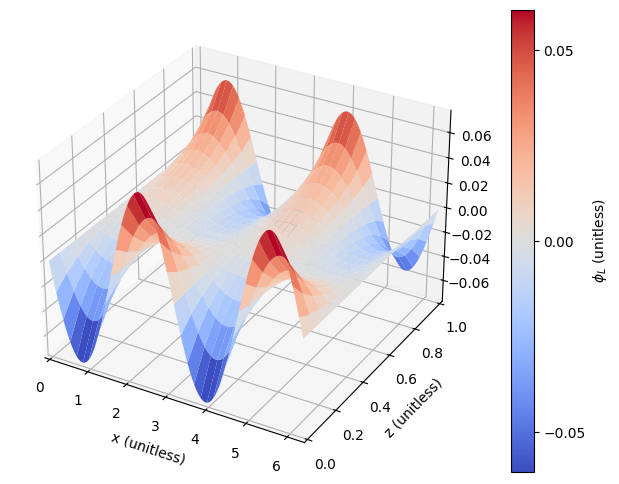

In [ ]:
X, Z = np.meshgrid(x, z)
fig, ax = plt.subplots(figsize=(10, 6),subplot_kw={'projection': '3d'})
surf = ax.plot_surface(X, Z, solver(H, beta_L, S,U), cmap='coolwarm')
cbar = plt.colorbar(surf, label='$ɸ_L$ (unitless)')
cbar.ax.set_yticks([-0.05,0,0.05])
ax.set_ylim(0,1)
ax.set_xlabel('x (unitless)')
ax.set_ylabel('z (unitless)')
ax.set_xlim(0,2*np.pi)
plt.show()

**Baseline Case**: Exponential decay and growth dominate $\phi_L$ with height. This demostrates positive and negative geopotential height anomalies typically associated with jet stream troughs and ridges. Ridges are indicated by positive anomalies in geopotential height while troughs are indicated by negative anomalies in geopotential height.

In [ ]:
analyticalsol = np.zeros([Nz,Nx])
rmsemat = np.zeros([Nz,Nx])
numericalsol = solver(H, beta_L, S,U)
q = np.sqrt(1/(4*H**2)-beta_L*S/U)
for m in range(Nz):
  for n in range(Nx):
    analyticalsol[m,n] = phi_func(x[n],z[m],q,H,U,n)
    rmsemat[m,n] = np.sqrt((numericalsol[m,n]-analyticalsol[m,n])**2)

# Plot 2. Error analysis of numerical solution according to the analytical solution

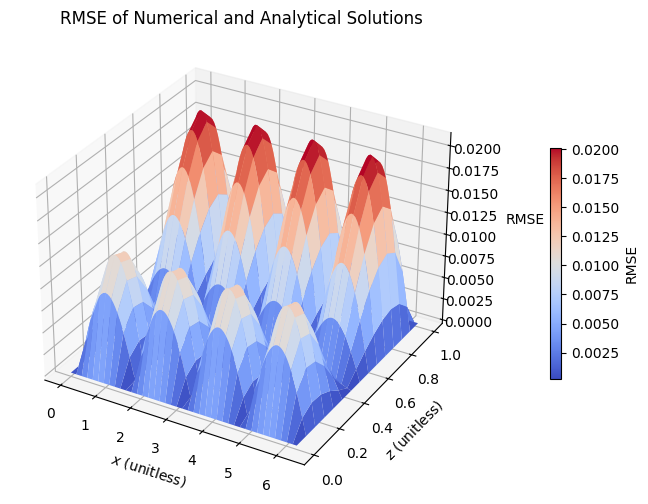

In [ ]:
X, Z = np.meshgrid(x, z)
fig, ax = plt.subplots(figsize=(10, 6),subplot_kw={'projection': '3d'})
surf = ax.plot_surface(X, Z, rmsemat, cmap="coolwarm")
cbar = plt.colorbar(surf, label="RMSE",shrink=0.5,pad=0.1)
plt.xlabel("$x$ (unitless)")
plt.ylabel("$z$ (unitless)")
ax.set_zlabel('RMSE',labelpad=14)
plt.title('RMSE of Numerical and Analytical Solutions')
plt.show()

**Root Mean Square Error**: The RMSE graph (based on an analytical solution to the equation) suggests that the error in our numerical solution comes from the numerics involved, and not the method itself. We can conclude this from the shape of the pulses in the RMSE figure: error is diminshed near the edges of the pulses, indicating that we resolve the locations of those pulses well, but the interiors of the pulses, especially in the upper part of the tropopause (0.5 < z < 1.0) are poorly resolved with respect to the magnitude of the streamfunction. As such, our time step may just be too great to appreciate the fine changes that add up to give the analytical solution its value. Still, most of the error points are at least 5-10x lower than the value of the numerical solution at the same point, giving us confidence in the accuracy our numerical solution.

# Plot 3. Geopotential Height Anomaly as a function of scale height

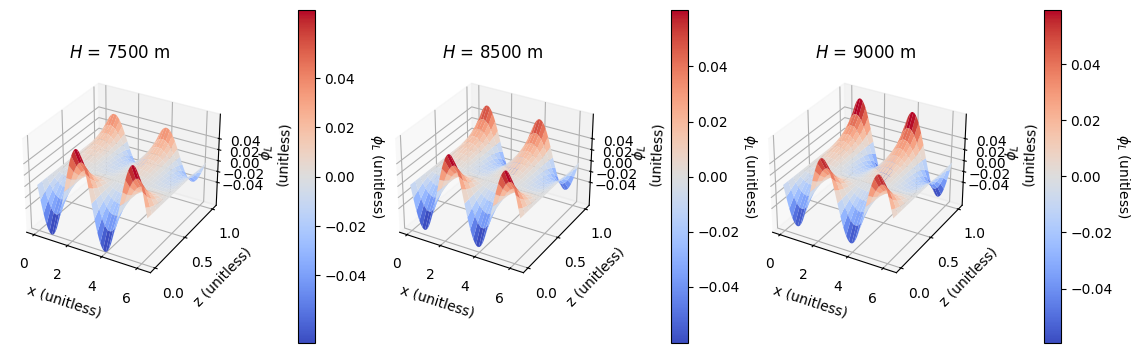

In [ ]:
Hlistreal = [7500,8500,9000]
Hlist = [np.nan,np.nan,np.nan]
for i in range(3):
  Hlist[i] = Hlistreal[i]*0.5/8500

fig, axs = plt.subplots(1,3,figsize=(14,14),subplot_kw={'projection': '3d'})
k = 0
for j in range(3):
    contourf_mappable=axs[j].plot_surface(X, Z, solver(Hlist[k], beta_L, S,U), cmap='coolwarm')
    cbar = plt.colorbar(contourf_mappable,label='$ɸ_L$ (unitless)',pad=0.2,shrink=0.1)
    cbar.set_label('$ɸ_L$ (unitless)',labelpad=14,rotation=270)
    cbar.set_ticks([-0.04,-.02,0.0,0.02,0.04])
    axs[j].set_ylabel('z (unitless)')
    axs[j].set_xlabel('x (unitless)')
    axs[j].set_zlabel('$ɸ_L$\n(unitless)')
    axs[j].set_zlim(-0.08,0.08)
    axs[j].set_zticks([-0.04,-.02,0.0,0.02,0.04])
    axs[j].set_yticks([0,0.50,1.00])
    axs[j].set_title(f'$H$ = {Hlistreal[k]} m')
    k+=1


fig.subplots_adjust(left=None, bottom=-1.5, right=None, top=None, wspace=0.1, hspace=None)

**Variable $H$**: Higher $H$ decreases magnitude of negative geopotential height anomalies and increases the magnitude of positive geopotential height anomalies. When $H$ increases, the ridges in geopotential height anomaly increase in height while the troughs in geipotential height anomaly decrease in height. The mean geopotential anomaly height value increases with respect to $H$. In the atmosphere, when the average temperature of an air column increases, the average height of that column of air also increases as a result of thermal expansion.

# Plot 4. Geopotential Height Anomaly with variable zonal winds

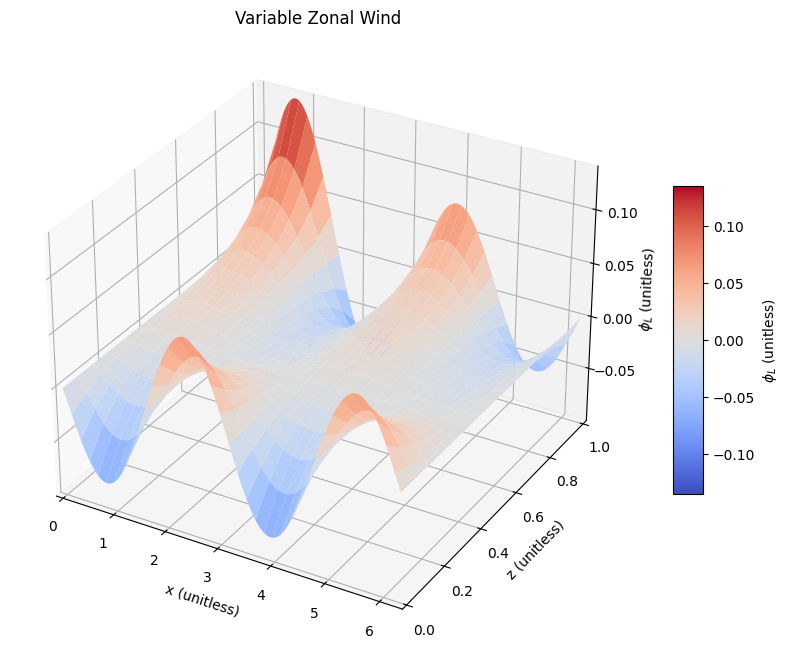

In [ ]:
def Uval(xarr):
    return 0.4 * xarr / (2 * np.pi) + 1.1

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
X, Z = np.meshgrid(x, z)
phi = np.zeros_like(X)

for i in range(Nx):
    phi[:,i] = solver(H,beta_L,S, Uval(x)[i])[:, i]

norm = Normalize(vmin=-max(abs(phi.min()), phi.max()), vmax=max(abs(phi.min()), phi.max()))
surf = ax.plot_surface(X, Z, phi, cmap='coolwarm', edgecolor='none', norm=norm)

cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('$ɸ_L$ (unitless)')
cbar.ax.set_yticks([-0.1,-0.05,0.0,0.05,0.10])
ax.set_xlabel('x (unitless)')
ax.set_ylabel('z (unitless)')
ax.set_title('Variable Zonal Wind')

ax.set_xlim(0, 2 * np.pi)
ax.set_ylim(0, 1)
ax.set_zlabel('$ɸ_L$ (unitless)')

plt.show()

**Non-Uniform $U(x)$**: Having a non-uniform $U(x)$, or zonal wind, amplifies geopotential anomalies in regions of weaker zonal winds. This is because the jet stream is defined by the strength of zonal winds $6-13$ kilometers above Earth's surface. Weaker zonal winds correlate with a weaker jet stream. A weaker jet stream meanders and helps to promote higher amplitude troughs and ridges. As zonal wind decreases, geopotential height anomalies increase in magnitude.

# Plot 5. Geopotential Height Anomaly with variable zonal winds as a function of scale height

<ipython-input-129-3a68b580648d>:22: RuntimeWarning: invalid value encountered in sqrt
  q = np.sqrt(1/(4*H**2)-beta_L*S/U)


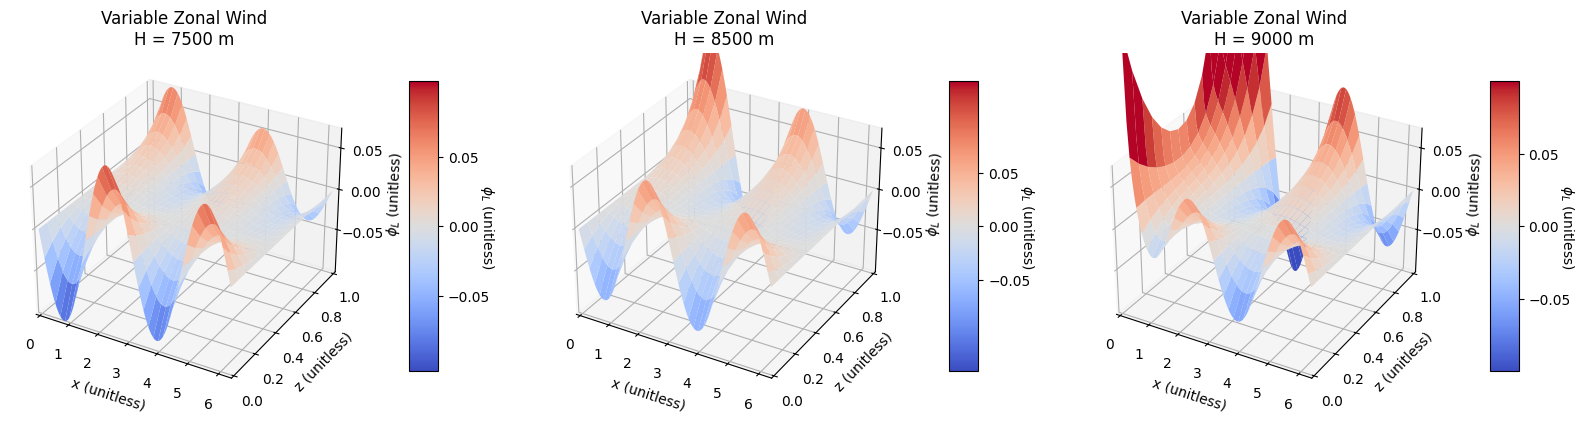

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20, 14),subplot_kw={'projection': '3d'})
X, Z = np.meshgrid(x, z)
phi = np.zeros_like(X)
for j in range(3):
  for i in range(Nx):
      phi[:,i] = solver(Hlist[j],beta_L,S, Uval(x)[i])[:, i]

  norm = Normalize(vmin=-max(abs(phi.min()), phi.max()), vmax=max(abs(phi.min()), phi.max()))
  surf = ax[j].plot_surface(X, Z, phi, cmap='coolwarm', edgecolor='none', norm=norm)

  cbar = fig.colorbar(surf, ax=ax[j], shrink=0.15, aspect=10,pad=0.11)
  cbar.set_label('$ɸ_L$ (unitless)',rotation=270)
  cbar.ax.set_yticks([-0.05,0.0,0.05])
  ax[j].set_xlabel('x (unitless)')
  ax[j].set_ylabel('z (unitless)')

  ax[j].set_zticks([-0.05,0.0,0.05])
  ax[j].set_zlim(-0.1,0.07)
  ax[j].set_title(f'Variable Zonal Wind\nH = {Hlistreal[j]} m')
  ax[j].set_zlabel('$ɸ_L$ (unitless)')

  ax[j].set_xlim(0, 2 * np.pi)
  ax[j].set_ylim(0, 1)
fig.subplots_adjust(left=None, bottom=-0.5, right=None, top=None, wspace=0.15, hspace=None)

plt.show()

**Non-Uniform $U(x)$ & Variable $H$**: Having a non-uniform $U(x)$, or zonal wind and variable $H$, or scale height, amplifies geopotential anomalies in regions of weaker zonal winds and amplifies the magnitude of positive geopotential height anomalies with respect to scale height. This is because weaker zonal winds result in a weaker jet stream and higher scale heights correlate with amplified ridges and positive geopotential height anomalies. As zonal wind decreases, geopotential height anomalies increase in magnitude. As scale height increases, the magnitude of positive geopotential height anomalies increases. When zonal wind decreases and scale height increases, positive geopotential anomalies significantly increase in magnitude while negative geopotential anomalies slightly increase in magnitude.

# Results

### How do results compare with known solutions

- **Comparison to Research Article**
The analytical solution and Plot 1 of *Wavier jet streams driven by zonally asymmetric surface thermal forcing* have similar solutions. The primary difference is that this project's analytical solution is in three dimensions, while Figure 1 has multiple two-dimensional displays. The numerical solution also strongly agrees with both the analytical solution and Plot 1 of *Wavier jet streams driven by zonally asymmetric surface thermal forcing*, according to our error analysis in Plot 2.

### How could model be improved with respect to the methods or processes included?
- Introduce nonlinear terms to model feedback mechanisms as well as model blocking patterns in trough and ridge flow.
- Increase vertical resolution $(N_z)$ for smoother transitions.

References:


W. Moon, B. Kim, G. Yang, J.S. Wettlaufer, Wavier jet streams driven by zonally asymmetric surface thermal forcing, Proc. Natl. Acad. Sci. U.S.A.

119 (38) e2200890119,

https://doi.org/10.1073/pnas.2200890119 (2022).